In [34]:
import librosa
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import joblib
import pandas as pd
import os
from shutil import copyfile

In [35]:
data_dir = Path('/home/hayden/proj/ml/meow_stop/data/')
meow_dir = Path(data_dir, 'meow/')
not_meow_dir = Path(data_dir, 'not_meow/')

In [36]:
# Create negatives

if len(os.listdir(not_meow_dir)) != 0: 
    raise Exception('Negatives directory isn\'t empty. Clear before proceeding.')

us8k_csv = '/home/hayden/proj/ml/meow_stop/UrbanSound8K/metadata/UrbanSound8K.csv'
us8k_df = pd.read_csv(us8k_csv)

classes = ['children_playing',
           'car_horn',
           'air_conditioner',
           'street_music',
           'siren',
           'engine_idling']

meow_dir = Path('/home/hayden/proj/ml/meow_stop/data/meow/')
not_meow_dir = Path('/home/hayden/proj/ml/meow_stop/data/not_meow/')
us8k_dir = Path('/home/hayden/proj/ml/meow_stop/UrbanSound8K/audio')

num_positives = len(list(meow_dir.glob('*.wav')))
num_negatives_per_class = int(num_positives / len(classes))
print('# positives: {}.'.format(num_positives))
print('# negatives: {}.'.format(num_negatives_per_class * len(classes)))

for c in classes:
    print('Processing negative class {}.'.format(c))
    
    # Grab num_negatives_per_class random files from the class
    class_rows = us8k_df[us8k_df['class'] == c]
    random_class_files = class_rows['slice_file_name'].sample(n=num_negatives_per_class)
    
    # Copy them to the dataset negatives directory
    random_class_files.apply(lambda f: copyfile(Path(us8k_dir, f), Path(not_meow_dir, f)))

# positives: 192.
# negatives: 192.
Processing negative class children_playing.
Processing negative class car_horn.
Processing negative class air_conditioner.
Processing negative class street_music.
Processing negative class siren.
Processing negative class engine_idling.


In [37]:
def load_data(data_dir):
    return [librosa.load(f)[0] for f in data_dir.glob('**/*.wav')]

In [38]:
meow_data = load_data(meow_dir)
not_meow_data = load_data(not_meow_dir)

In [39]:
def extract_features(data):
    clip_features = []
    
    for clip in data:
        mfcc = librosa.feature.mfcc(y=clip, sr=22050, n_mfcc=40)
        mfcc_avgs = np.mean(mfcc, axis=1)
        clip_features.append(mfcc_avgs)
    
    return np.stack(clip_features, axis=0)

In [40]:
meow_extracted_features = extract_features(meow_data)
meow_labels = np.ones(len(meow_extracted_features))
not_meow_extracted_features = extract_features(not_meow_data)
not_meow_labels = np.zeros(len(not_meow_extracted_features))

In [41]:
print(meow_extracted_features.shape)
print(not_meow_extracted_features.shape)

(192, 40)
(192, 40)


In [42]:
x = np.concatenate((meow_extracted_features, not_meow_extracted_features), axis=0)
y = np.concatenate((meow_labels, not_meow_labels), axis=0)

print('x shape: {}.'.format(x.shape))
print('y shape: {}.'.format(y.shape))

x shape: (384, 40).
y shape: (384,).


In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [44]:
y_pred = model.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [45]:
joblib.dump(model, 'models/model.pkl')

['models/model.pkl']

In [107]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

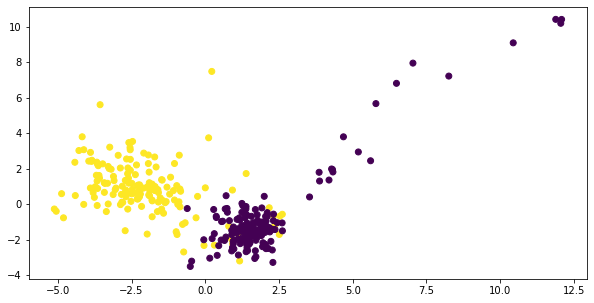

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x_pca[:, 0], x_pca[:, 1], c=y)